In [1]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
print("Bắt đầu quá trình huấn luyện mô hình (Phiên bản Nâng cao)...")

# --- 1. Định nghĩa Cấu trúc Dữ liệu (Dựa trên adult.names) ---

# Đường dẫn đến file data 
DATA_FILE = '../data/adult.data'
MODEL_DIR = Path('../assets/models')
MODEL_DIR.mkdir(parents=True, exist_ok=True) # Tạo thư mục nếu chưa có

# Tên cột
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 'income']

# (Giải pháp 1 & 3) Định nghĩa tất cả các hạng mục có thể có, bao gồm '?'
categorical_features = {
    'workclass': ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked', '?'],
    'marital-status': ['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse', '?'],
    'occupation': ['Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing', 'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces', '?'],
    'relationship': ['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried', '?'],
    'race': ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black', '?'],
    'sex': ['Female', 'Male', '?'],
    'native-country': ['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands', '?']
}

Bắt đầu quá trình huấn luyện mô hình (Phiên bản Nâng cao)...


In [3]:
# --- 2. Tải và Tiền xử lý Dữ liệu ---

try:
    # (Giải pháp 1) KHÔNG dùng na_values=' ?' nữa, để '?' được đọc như một giá trị
    df = pd.read_csv(DATA_FILE, header=None, names=columns, sep=',\s*', engine='python')
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file dữ liệu tại: {DATA_FILE}")
    exit()

print("Đã tải dữ liệu, bắt đầu tiền xử lý...")

# (Giải pháp 2) Bỏ các cột không cần thiết/thừa thãi
# fnlwgt: Là trọng số, không phải đặc trưng của cá nhân
# education: Thừa vì đã có education-num
df_processed = df.drop(['fnlwgt', 'education'], axis=1)

# Xử lý cột mục tiêu (income)
# Thêm .str.strip('.') để xử lý lỗi tiềm ẩn trong file test (nếu dùng)
df_processed['income'] = df_processed['income'].str.strip('.')
le = LabelEncoder()
df_processed['income'] = le.fit_transform(df_processed['income']) # <=50K = 0, >50K = 1

# Tách X (đặc trưng) và y (nhãn)
X = df_processed.drop('income', axis=1)
y = df_processed['income']

# (Giải pháp 3) Áp dụng kiểu Categorical Dtype để fix các hạng mục
for col, cats in categorical_features.items():
    if col in X.columns:
        cat_type = pd.CategoricalDtype(categories=cats, ordered=False)
        X[col] = X[col].astype(cat_type)

# (Giải pháp 3) Chạy One-Hot Encoding
# drop_first=True để giảm số chiều, tránh đa cộng tuyến
X_processed = pd.get_dummies(X, columns=categorical_features.keys(), drop_first=True)

# Lưu lại danh sách các cột đã xử lý
model_columns = list(X_processed.columns)
joblib.dump(model_columns, MODEL_DIR / 'model_columns.joblib')
print(f"Đã lưu danh sách {len(model_columns)} cột (đã One-Hot Encoded) vào 'model_columns.joblib'")

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Admin\AppData\Local\Temp\ipykernel_15144\2941199057.py:5: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(DATA_FILE, header=None, names=columns, sep=',\s*', engine='python')


Đã tải dữ liệu, bắt đầu tiền xử lý...
Đã lưu danh sách 88 cột (đã One-Hot Encoded) vào 'model_columns.joblib'


In [4]:
# --- 3. Huấn luyện và Đánh giá Mô hình ---
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

print("Đang huấn luyện mô hình Decision Tree...")
# (Sửa lỗi 0/100%) Giới hạn độ sâu để tránh overfitting và cho xác suất hợp lý
model = DecisionTreeClassifier(max_depth=6, random_state=42) 
model.fit(X_train, y_train)

# Lưu mô hình
joblib.dump(model, MODEL_DIR / 'adult_model.joblib')
print(f"Đã lưu mô hình vào 'adult_model.joblib' tại {MODEL_DIR}")

Đang huấn luyện mô hình Decision Tree...
Đã lưu mô hình vào 'adult_model.joblib' tại ..\assets\models


In [5]:
# --- 4. Xuất 2 OUTPUT theo yêu cầu ---
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("---------------------------------------------------------")
print(f"✅ OUTPUT 1: Accuracy của mô hình = {accuracy * 100:.2f}%")
print("---------------------------------------------------------")

---------------------------------------------------------
✅ OUTPUT 1: Accuracy của mô hình = 85.32%
---------------------------------------------------------


Đang tạo biểu đồ Feature Importance...
✅ OUTPUT 2: Đã lưu biểu đồ vào '..\assets\models\feature_importance.png'
--- Quá trình huấn luyện hoàn tất! ---


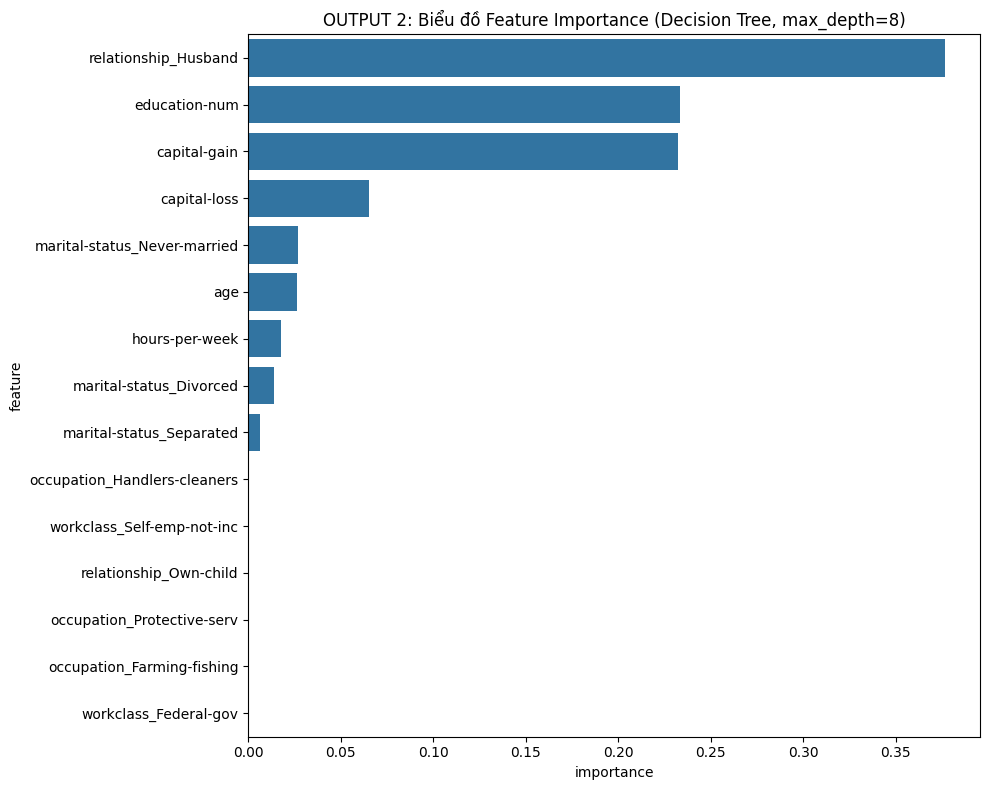

In [7]:
# Vẽ và Lưu Biểu đồ Feature Importance
print("Đang tạo biểu đồ Feature Importance...")

importances = model.feature_importances_
feature_names = X_processed.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('OUTPUT 2: Biểu đồ Feature Importance (Decision Tree, max_depth=8)')
plt.tight_layout()
plt.savefig(MODEL_DIR / 'feature_importance.png')

print(f"✅ OUTPUT 2: Đã lưu biểu đồ vào '{MODEL_DIR / 'feature_importance.png'}'")
print("--- Quá trình huấn luyện hoàn tất! ---")